# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [49]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

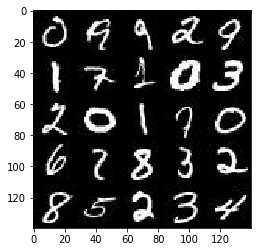

In [50]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

##### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

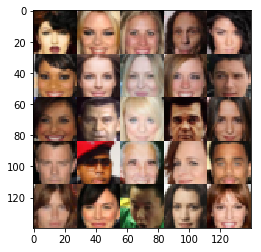

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")

    return input_real,input_z,learning_rate_pl


"""
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

SyntaxError: EOL while scanning string literal (<ipython-input-53-093f3394d6be>, line 22)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.20
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1,4*4*256))
        
        logits= tf.layers.dense(flattened,1)
        out= tf.sigmoid(logits)
    
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train
    alpha = 0.10
    with tf.variable_scope('generator',reuse=reuse_state): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid' )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same')    
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
   
   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list= g_vars)
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list= d_vars)
    
        return d_opt_train, g_opt_train



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [59]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    steps = 0
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                
                
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,n_images,input_z,image_channels,data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.8515... Generator Loss: 0.0135
Epoch 1/2... Discriminator Loss: 2.8740... Generator Loss: 0.1294
Epoch 1/2... Discriminator Loss: 2.9442... Generator Loss: 0.1159
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 1.8184... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.7336... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.6629... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.7280... Generator Loss: 0.6815


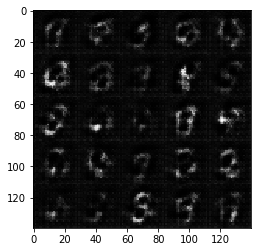

Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 1.7522... Generator Loss: 0.5493
Epoch 1/2... Discriminator Loss: 1.9155... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.9424... Generator Loss: 0.2811
Epoch 1/2... Discriminator Loss: 1.7016... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 1.6671... Generator Loss: 0.3840
Epoch 1/2... Discriminator Loss: 1.5704... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 1.5737... Generator Loss: 0.4294


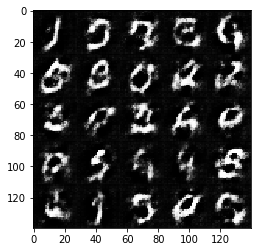

Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.4005
Epoch 1/2... Discriminator Loss: 1.6709... Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 1.5091... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 1.3339
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5016
Epoch 1/2... Discriminator Loss: 1.5965... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.5156... Generator Loss: 0.4675


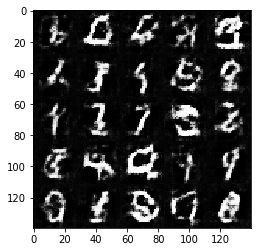

Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.4473
Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.6120... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.6728... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 1.5612... Generator Loss: 0.4260


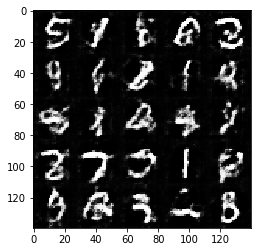

Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.4157
Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.7042... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.4359


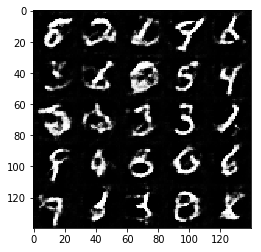

Epoch 1/2... Discriminator Loss: 1.5830... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 1.1739
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.5723


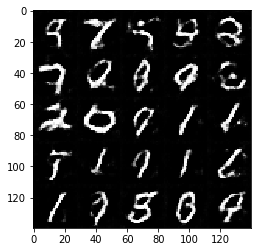

Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 1.0074
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.7383


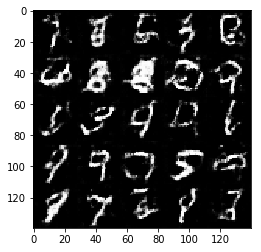

Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.9726... Generator Loss: 0.2280
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.5016


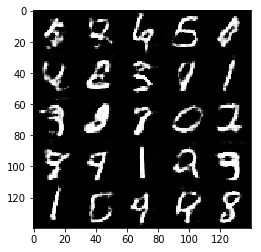

Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.7107... Generator Loss: 1.3679
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.6645... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 1.2645
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.5772


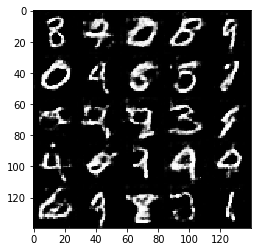

Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 1.6240... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.5568
Epoch 2/2... Discriminator Loss: 1.6519... Generator Loss: 0.3752
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.5479... Generator Loss: 0.4493
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.5146


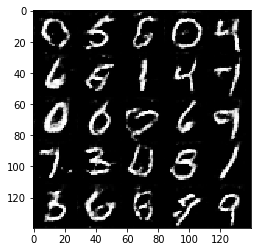

Epoch 2/2... Discriminator Loss: 1.6163... Generator Loss: 0.3930
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 1.6940... Generator Loss: 0.3283
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.8173... Generator Loss: 0.2932
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.6917


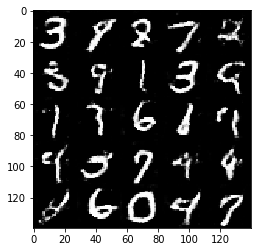

Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6053
Epoch 2/2... Discriminator Loss: 1.8584... Generator Loss: 0.2790
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 0.3976
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 0.4724


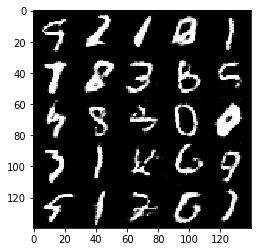

Epoch 2/2... Discriminator Loss: 1.5980... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.6281
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 1.5233... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 1.7877... Generator Loss: 0.3218
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.7918


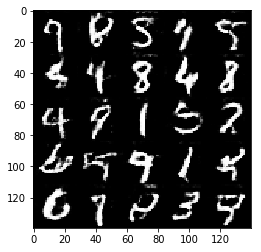

Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.6325... Generator Loss: 1.2395
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.8904... Generator Loss: 0.2719
Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.6660... Generator Loss: 1.3025


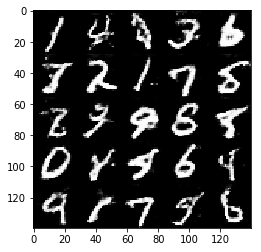

Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6816
Epoch 2/2... Discriminator Loss: 1.6854... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 1.0022
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 0.4942


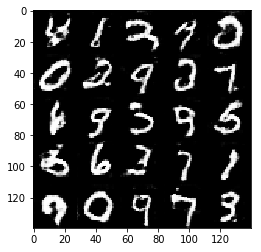

Epoch 2/2... Discriminator Loss: 1.6804... Generator Loss: 0.3663
Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.9681
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 1.2094
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.8790... Generator Loss: 0.2621
Epoch 2/2... Discriminator Loss: 1.6755... Generator Loss: 0.3466
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.4876
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.4700


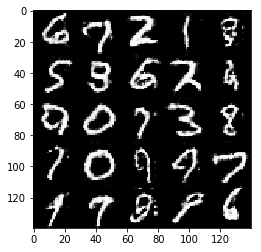

Epoch 2/2... Discriminator Loss: 1.7965... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 1.1331
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 1.8718
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.5877... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.5551
Epoch 2/2... Discriminator Loss: 1.6067... Generator Loss: 1.7232
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.6680


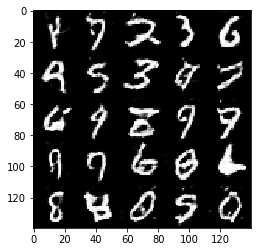

Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.1528
Epoch 2/2... Discriminator Loss: 1.4855... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.7662... Generator Loss: 0.3094
Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 1.5133... Generator Loss: 0.4406
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.8812


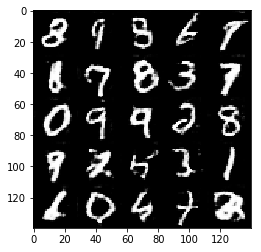

Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.5463... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 1.6266... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.4815... Generator Loss: 1.5399


In [60]:
batch_size = 64
z_dim = 130
learning_rate = 0.0005
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4551... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 3.2396
Epoch 1/1... Discriminator Loss: 2.6010... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 4.7352
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 3.3288
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 3.2244
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.4737


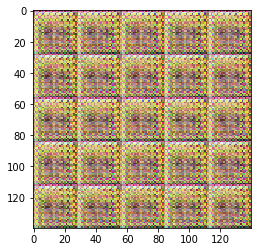

Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 2.9740
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.7435


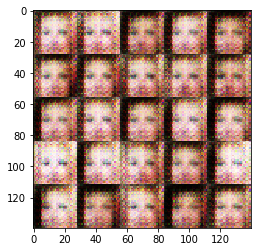

Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.6695... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6319


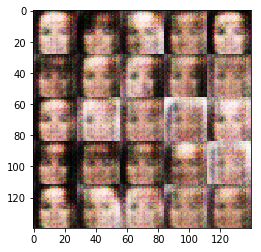

Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.7490


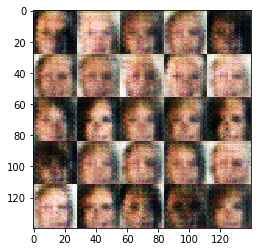

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6497


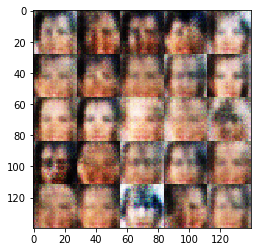

Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7529


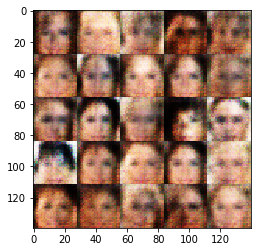

Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8433


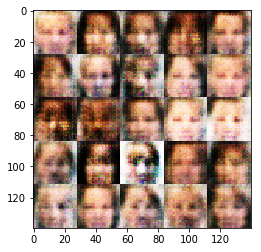

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7780


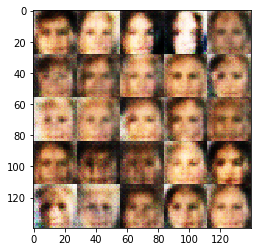

Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7335


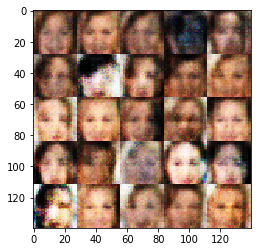

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6911


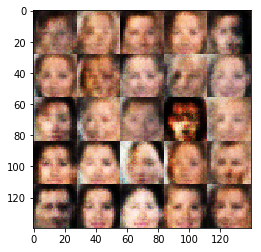

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7693


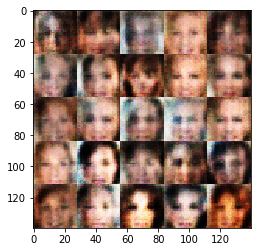

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7609


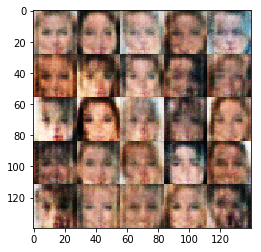

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7651


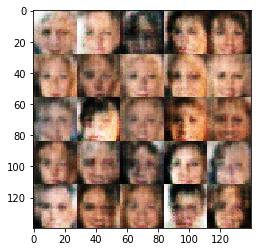

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7834


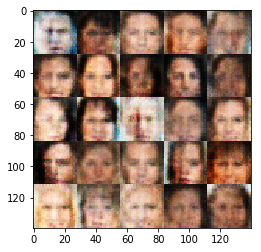

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7057


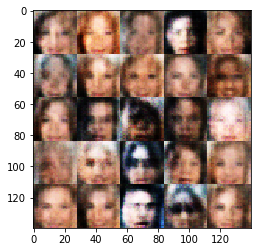

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8506


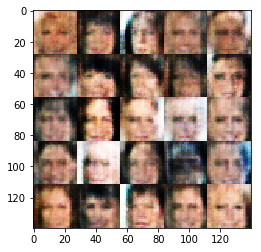

Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7157


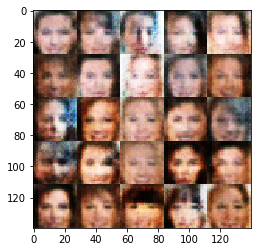

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7314


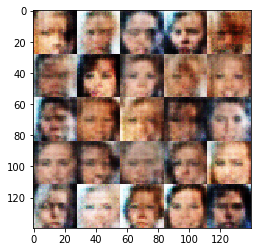

Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7467


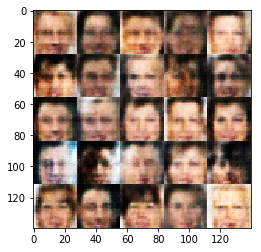

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7787


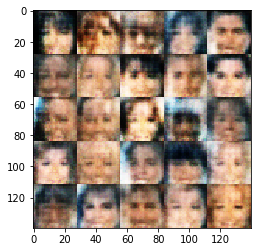

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7598


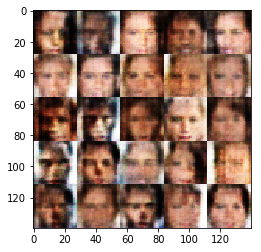

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8500


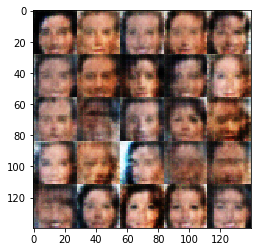

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8355


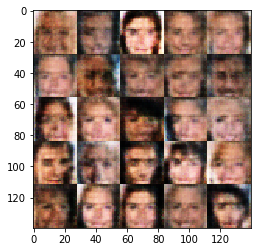

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7418


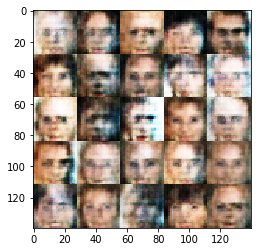

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8129


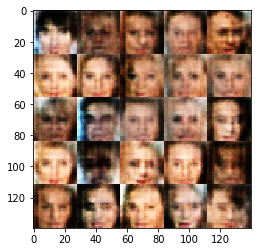

Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7732


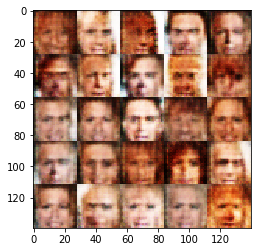

Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8176


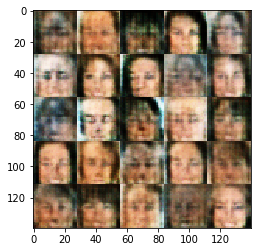

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6816


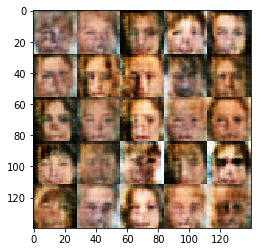

Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7284


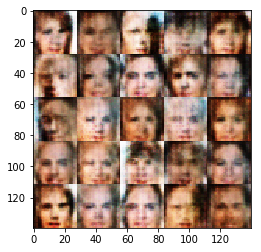

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7979


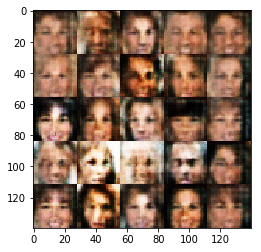

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7157


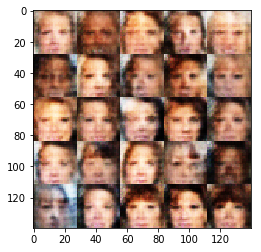

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7253


In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.